### Figure 3
 - Explained variance each subject individually
 

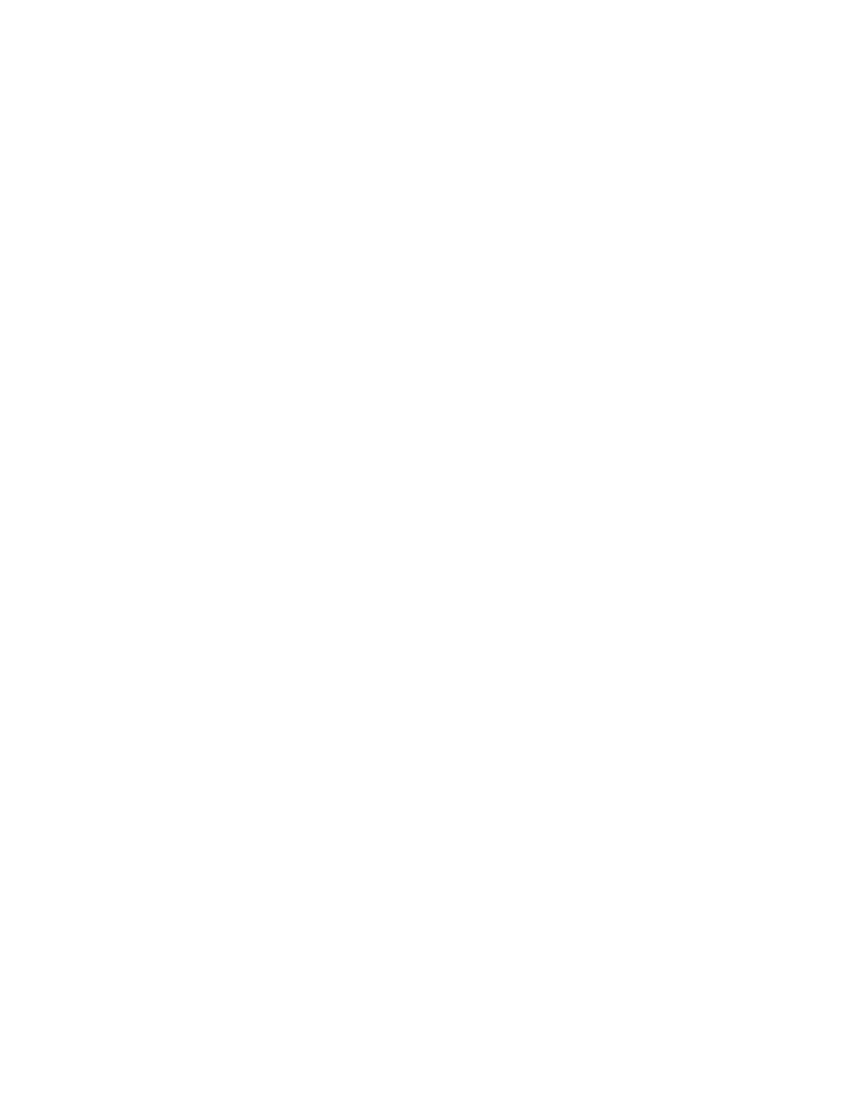

In [88]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
import pandas as pd
import subjects
from subjects import sns_boxplot_kw,stat_kw
from neuropy import plotting
from statannotations.Annotator import Annotator

grpdata = subjects.GroupData()
group = ["NSD", "SD"]

ev_states = grpdata.ev_brainstates
ev_df = grpdata.ev_pooled
# ev_df["ev_diff"] = ev_df["ev"] - ev_df["rev"]
ev_pooled = grpdata.ev_in_chunks 

fig = plotting.Fig(grid=(10, 4))
filename = subjects.figpath_sd / "figure3"
caption = "Figure 3: MAZE reactivation during POST. \n(A) Explained variance (EV) in POST for each session of SD (orange) and NSD (purple) group with chance levels (gray). Error bars indicate +/- stdev. \n(B) Mean explained variance pooled across SD and NSD sessions. Error bars indicate +/- SEM."


### Individual EVs

In [89]:
from neuropy.plotting import plot_hypnogram
from neuropy.core import Epoch

# y_lim = [0.4, 0.2, 0.27, 0.15, 0.27, 0.25]
errorbar_kw = dict(alpha=0.5, linewidth=0, ec=None)
names = ev_df.name.unique()
ev_colors = [subjects.nsd.color(1.2), subjects.sd.color(1.2)]

for row, name in enumerate(names):
    df_name = ev_df[ev_df.name == name]
    states_name = ev_states[ev_states.name == name]
    sex = df_name.sex.iloc[0]
    grps_name = df_name.grp.unique()[::-1]

    subfig = fig.fig.add_subfigure(fig.gs[row, :2])
    axs = subfig.subplots(2, 2, sharey="row", gridspec_kw=dict(height_ratios=[1, 4]))

    for i, grp in enumerate(grps_name):
        states = states_name[states_name["grp"] == grp]
        df = df_name[df_name["grp"] == grp]
        color = ev_colors[0] if grp == "NSD" else ev_colors[1]
        col = 0 if grp == "NSD" else 1

        t, ev, ev_err, rev, rev_err = (
            df["Zt"],
            df["ev"],
            df["ev_std"],
            df["rev"],
            df["rev_std"],
        )

        ax_hypno, ax = axs[:, col]

        epoch = Epoch(states)
        plot_hypnogram(epoch, ax=ax_hypno, collapsed=False)

        ax.fill_between(t, rev - rev_err, rev + rev_err, color="gray", **errorbar_kw)
        ax.plot(t, rev, color="gray")
        ax.fill_between(t, ev - ev_err, ev + ev_err, color=color, **errorbar_kw)
        ax.plot(t, ev, color=color)

        sex_symbol = "$\u2640$" if sex == "female" else "$\u2642$"
        sex_color = "#F50057" if sex == "female" else "#2962FF"
        if i == 0:
            ax.set_ylabel("EV")
            fig.legend(ax, [name + sex_symbol], color=[sex_color], x=-0.4, y=1)

        ax.set_xticks([1, 3, 5, 7, 9])

### Pooled Evs

In [90]:
ax = fig.subplot(fig.gs[:1, 2])
plot_kw = dict(
    data=ev_pooled, x="zt", y="ev_diff", hue="grp", hue_order=group, width=0.5, ax=ax
)
sns.boxplot(**plot_kw, **sns_boxplot_kw)
ax.tick_params("x", rotation=30)
ax.set_ylabel("Explained variance diff")
ax.set_xlabel("")
ax.legend('',frameon=False)
# stats
orders = ev_pooled.zt.unique()
pairs = [((_, "NSD"), (_, "SD")) for _ in orders]
annotator = Annotator(pairs=pairs, **plot_kw, order=orders)
annotator.configure(test="Mann-Whitney", **stat_kw)

annotator.apply_and_annotate()
annotator.reset_configuration()


p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

0-2.5_NSD vs. 0-2.5_SD: Mann-Whitney-Wilcoxon test two-sided, P_val:1.014e-01 U_stat=3.300e+01
2.5-5_NSD vs. 2.5-5_SD: Mann-Whitney-Wilcoxon test two-sided, P_val:1.375e-01 U_stat=3.200e+01
5-7.5_NSD vs. 5-7.5_SD: Mann-Whitney-Wilcoxon test two-sided, P_val:6.282e-01 U_stat=1.700e+01


### saving

meta NOT subset; don't know how to subset; dropped
meta NOT subset; don't know how to subset; dropped
meta NOT subset; don't know how to subset; dropped


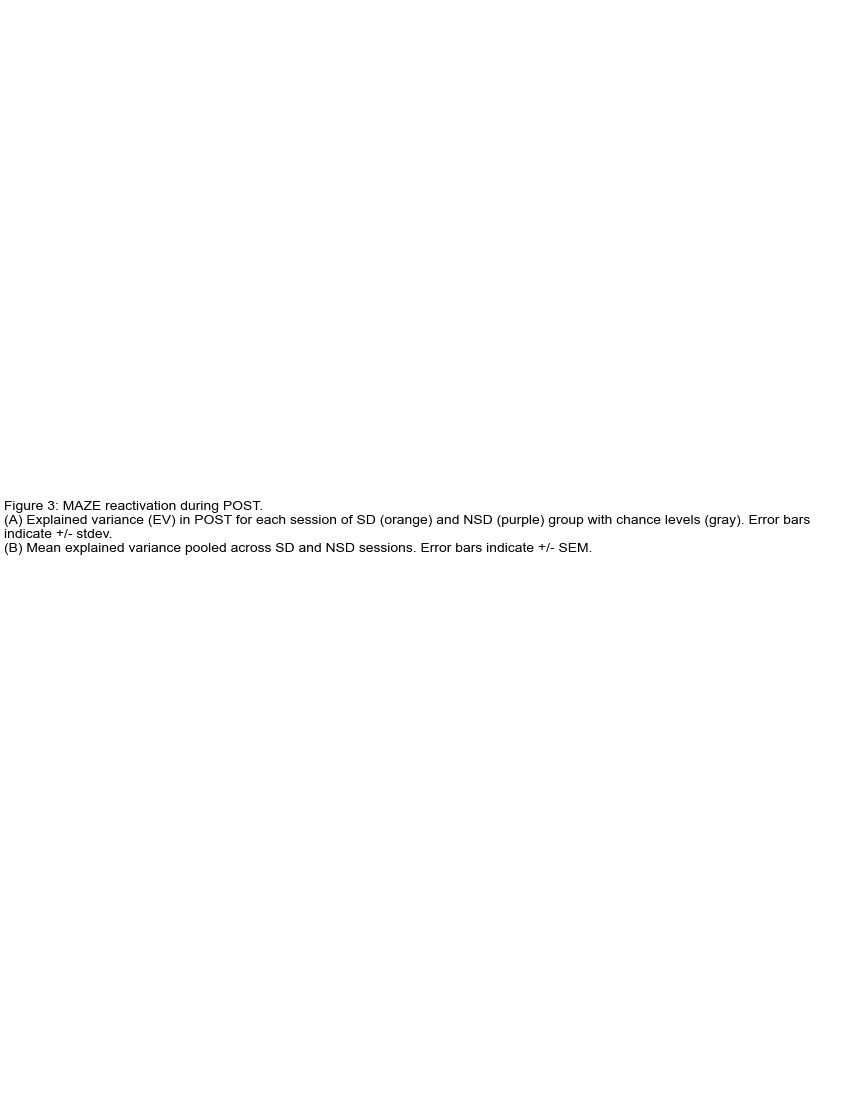

In [91]:
fig.savefig(filename,caption=caption)